In [3]:
# from pyicecake import pyicecake
import numpy as np
import types
import collections
from random import shuffle
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import PIL
from PIL import Image
import cupy as cp
from timeit import default_timer as timer
from matplotlib.pyplot import imshow
import cv2
import os
from tqdm.notebook import trange, tqdm
%matplotlib inline

In [4]:
file = "/mnt/optane-ssd/lipeng/imagenet/5000/train/n01443537/n01443537_10007.JPEG"

In [5]:
npbuff = np.asarray(PIL.Image.open(file), dtype=np.uint8)

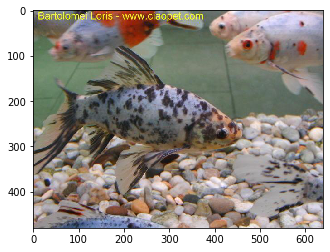

In [6]:
imshow(npbuff)

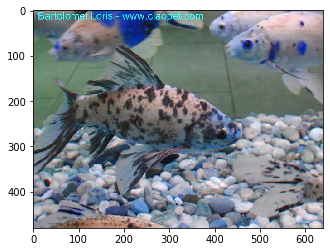

In [7]:
img_bgr = cv2.imread(file)
imshow(img_bgr)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
#imshow('RGB Image',img_rgb )

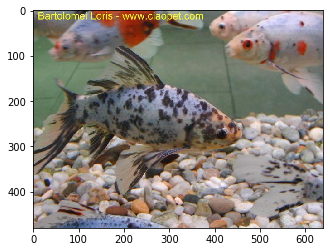

In [8]:
imshow(img_rgb)


In [12]:
type(img_rgb)
np.array_equal(img_rgb, npbuff)

False

In [13]:
diffs = npbuff - img_rgb

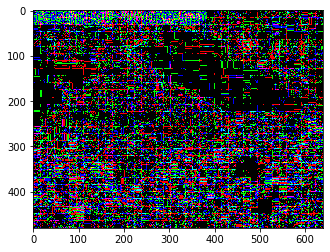

In [15]:
imshow(np.abs(img_rgb - npbuff))

In [6]:
import torchvision.transforms as transforms
import torchvision.transforms.functional as fc
def RandomResizedCrop_stage1(img, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.)):
    i, j, h, w = transforms.RandomResizedCrop.get_params(img, scale, ratio)
    img = fc.crop(img, i, j, h, w)
    return img
    
def RandomResizedCrop_stage2(img, size, interpolation=Image.BILINEAR):
    return fc.resize(img, (size,size), interpolation)
t1 = transforms.Compose([
            transforms.RandomResizedCrop(224),
#             transforms.RandomHorizontalFlip()
        ])

In [7]:
img = Image.open(file)# 读取图像

In [8]:
img1 = t1(img)

In [9]:
img2_1 = RandomResizedCrop_stage1(img)
img2_2 = RandomResizedCrop_stage2(img2_1, 224)

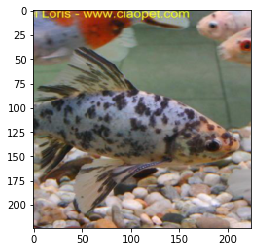

In [10]:
imshow(img1)

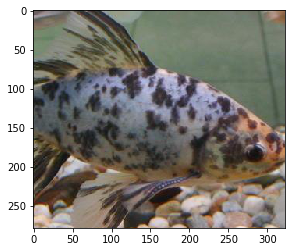

In [11]:
imshow(img2_1)

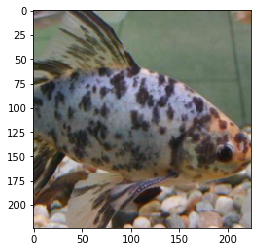

In [12]:
imshow(img2_2)

In [13]:
img1.save("/tmp/o2.JPEG", quality=100,subsampling=0)
img1.save("/tmp/o.png")

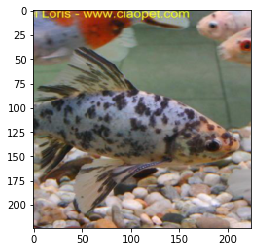

In [14]:
npbuff2 = np.asarray(PIL.Image.open("/tmp/o.png"), dtype=np.uint8)
imshow(npbuff2)

In [15]:
npbuff3 = np.asarray(img1)

In [16]:
np.array_equal(npbuff3, npbuff2)

True

In [17]:
npbuff3

array([[[ 49,  41,  71],
        [ 79,  64, 104],
        [128, 118, 111],
        ...,
        [210, 202, 222],
        [207, 201, 220],
        [209, 202, 220]],

       [[116, 112,  81],
        [140, 124, 141],
        [178, 164, 151],
        ...,
        [213, 203, 220],
        [211, 204, 220],
        [213, 204, 220]],

       [[208, 217,  74],
        [180, 172, 118],
        [190, 181, 117],
        ...,
        [215, 203, 218],
        [214, 205, 218],
        [214, 204, 217]],

       ...,

       [[ 83,  64,  83],
        [ 95,  77,  91],
        [111,  94, 100],
        ...,
        [233, 219, 229],
        [232, 218, 229],
        [229, 220, 233]],

       [[ 87,  50,  39],
        [ 81,  44,  38],
        [ 77,  41,  42],
        ...,
        [232, 218, 233],
        [229, 214, 232],
        [222, 213, 231]],

       [[138,  95,  63],
        [120,  75,  51],
        [ 97,  51,  39],
        ...,
        [226, 214, 228],
        [222, 211, 227],
        [218, 209, 224]]

In [18]:
file_list = "/mnt/optane-ssd/lipeng/imagenet/train.txt"
filenames = []
lines = []
with open(file_list, 'r') as f:
    lines = f.readlines()
for l in lines:
    filenames.append(l.split(" ")[0].strip())

In [19]:
print(len(filenames))
filenames[:10]

1281167


['train/n01688243/n01688243_11073.JPEG',
 'train/n01688243/n01688243_2174.JPEG',
 'train/n01688243/n01688243_11682.JPEG',
 'train/n01688243/n01688243_318.JPEG',
 'train/n01688243/n01688243_6050.JPEG',
 'train/n01688243/n01688243_10694.JPEG',
 'train/n01688243/n01688243_2954.JPEG',
 'train/n01688243/n01688243_4229.JPEG',
 'train/n01688243/n01688243_2170.JPEG',
 'train/n01688243/n01688243_433.JPEG']

In [20]:
filecontents = []
for f in filenames[:10000]:
    fpath = "/mnt/optane-ssd/lipeng/imagenet/"+f
    filecontents.append(Image.open(fpath))
    

In [30]:
def crop_image(img):
    img1 = t1(img)
#     img1.save("/tmp/out.JPEG")
#     new_size = os.path.getsize("/tmp/out.JPEG")
#     return ori_size,new_size

def crop_save_image(f, fout="/tmp/out.JPEG"):
    fpath = "/mnt/optane-ssd/lipeng/imagenet/"+f
    ori_size = os.path.getsize(fpath)
    img = Image.open(fpath)
    img1 = t1(img)
    img1.save(fout)
    new_size = os.path.getsize("/tmp/out.JPEG")
    return ori_size,new_size


In [22]:
# for i in trange(len(filecontents[:])):
#     crop_image(filecontents[i])

In [ ]:
ori_size_list = []
new_size_list = []
total_reduced_size = 0
for i in trange(len(filenames[:])):
    ori,news = crop_save_image(filenames[i])
    ori_size_list.append(ori)
    new_size_list.append(news)
    total_reduced_size += ori-news
print(total_reduced_size)

In [ ]:
# print(total_reduced_size/1024.)
print("ave reduced size: {0:.6}KB".format(total_reduced_size/len(new_size_list)/1024.))
print("total reduced size: {:.6}GB, ratio:{:.6}%".format(total_reduced_size/1024./1024/1024, 100*total_reduced_size/np.asarray(ori_size_list).sum()))
print("total size:{:.6}GB".format(np.asarray(ori_size_list).sum()/1024./1024/1024))
print("size: {:.6}GB".format(np.asarray(new_size_list).sum()/1024./1024/1024))

In [ ]:
np.asarray(ori_size_list).sum()

In [ ]:
np.asarray(new_size_list).sum()

In [ ]:
11897434198/1024./1024/1024

In [ ]:
import pickle

In [ ]:
with open('ori_size_list.pickle', 'wb') as f:
    pickle.dump(ori_size_list, f)
with open('new_size_list.pickle', 'wb') as f:
    pickle.dump(new_size_list, f)

read from disk/net -> decode -> transform -> tensor_copy -> computation

In [23]:
fcontent = []
images = []
def read_from_disk(f):
    fpath = "/mnt/optane-ssd/lipeng/imagenet/"+f
    with open(fpath, "rb") as fi:
        fcontent.append(fi.read())
def pil_read_decode(f):
    fpath = "/mnt/optane-ssd/lipeng/imagenet/"+f
    images.append(Image.open(fpath))
def crop_image(img):
    img1 = t1(img)
    return img1
#     img1.save("/tmp/out.JPEG")
#     new_size = os.path.getsize("/tmp/out.JPEG")
#     return ori_size,new_size

In [31]:
# crop and save images
for i in trange(len(filenames[:10000])):
    crop_save_image(filenames[i], "/mnt/optane-ssd/lipeng/imagenet/cropped/" + filenames[i].split("/")[-1])

In [24]:
from timeit import default_timer as timer

n_test = 0
t_start = timer()
for i in trange(len(filenames[30000:40000])):
    read_from_disk(filenames[i])
    n_test+=1
t = timer() - t_start
print("time: {}".format(t))
print("Speed: {} imgs/s".format((n_test)/t))


time: 0.740496389567852
Speed: 13504.454769638949 imgs/s


In [25]:
n_test = 0
t_start = timer()
for i in trange(len(filenames[30000:40000])):
    pil_read_decode(filenames[i])
    n_test+=1
t = timer() - t_start
print("time: {}".format(t))
print("Speed: {} imgs/s".format((n_test)/t))


time: 0.8262571319937706
Speed: 12102.769964441763 imgs/s


In [26]:
n_test = 0
t_start = timer()
for i in trange(len(images[:])):
    crop_image(images[i])
    n_test+=1
t = timer() - t_start
print("time: {}".format(t))
print("Speed: {} imgs/s".format((n_test)/t))


time: 49.10322494339198
Speed: 203.65261164675786 imgs/s


In [27]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
class MixedPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(MixedPipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.FileReader(file_root = "/mnt/optane-ssd/lipeng/imagenet/train", random_shuffle = False)
#         self.input = ops.FileReader(file_root = "/home/lwangay/dali-data/images/", random_shuffle = True)
        self.decode = ops.ImageDecoder(device = 'mixed', output_type = types.RGB)
        self.crop = ops.RandomResizedCrop(device='gpu', size=[224,224])
#         self.rotate = ops.Rotate(device='gpu')
#         self.rng = ops.Uniform(range = (-30.0, 30.0))
    def define_graph(self):
        jpegs, labels = self.input()
        res = self.decode(jpegs)
        res = self.crop(res)
#         angle = self.rng()
#         res = self.rotate(res, angle=angle)
        return (res, labels)

In [28]:
pipe = MixedPipeline(batch_size=1, num_threads=4, device_id = 0)
pipe.build()

n_test = 0
t_start = timer()
for i in trange(len(images[:])):
    img,label=pipe.run()
    n_test+=1
t = timer() - t_start
print("time: {}".format(t))
print("Speed: {} imgs/s".format((n_test*1)/t))


time: 15.234298172406852
Speed: 656.4135667314505 imgs/s
